In [109]:
# Get the population from a CCEA that learned with dynamic influence
# Just 1 uav and 1 rover
# Generate 50 new joint trajectories with random poi locations
# Now I have many joint trajectories, and the policies those joint trajectories came from

# Give me a histogram of the performance of each run
# Give me a histogram of the influence from uav to rover in each run (hard-coded influence)
# Compute influence based on counterfactual what-ifs of what the rover would have done without the uav if the uav were removed
# (and I can compute this perfectly because I have the exact policy of the rover and I can reconstruct the environment with the uav removed)
# Now give me a histogram of that

In [110]:
from pathlib import Path
from typing import List, Optional, Any
import os
import cppyy
import pandas as pd
import pickle
from copy import deepcopy
import numpy as np
import yaml
import matplotlib.pyplot as plt
from influence.plotting import plot_joint_trajectory, generate_joint_trajectory_plot, PlotArgs
from influence.ccea_lib import CooperativeCoevolutionaryAlgorithm, TeamInfo, NeuralNetwork, EvalInfo, JointTrajectory
from influence.custom_env import createAgent, createHiddenPOI
from influence.librovers import rovers, thyme
from matplotlib import font_manager

In [111]:
# Let's load in a population
base_dir = Path(
    os.path.expanduser(
        '~/influence-shaping/results/01_05_2025/yabby/31_more_circles/1x1/D-Indirect-Timestep-no-preservation'
    )
)
population_dir = base_dir / 'trial_0' / 'checkpoint_1000.pkl'
with open(population_dir, "rb") as file:
    population = pickle.load(file)

In [112]:
# Let's get a team (if I remember correctly, the leftmost index of each subpopluation should have the elite for that subpop)
elite_team = [subpop[0] for subpop in population]

# Set up to run the team in the environment
t_infos = [
    TeamInfo(
        policies=elite_team,
        seed=i
    )
    for i in range(50)
]
template_policies = [
    NeuralNetwork(
        num_inputs=12, 
        num_hidden=[15], 
        num_outputs=2, 
        hidden_activation_func='tanh', 
        output_activation_func='tanh'
    )
]*2
config_dir = base_dir / 'config.yaml'
with open(str(config_dir), 'r') as file:
    config = yaml.safe_load(file)

# Let's run that team 50 times in the environment
outs = []
for team_info in t_infos:
    out = CooperativeCoevolutionaryAlgorithm.evaluateTeamStatic(
        team = team_info, 
        template_policies = template_policies,
        config=config,
        num_rovers=1,
        num_uavs=1,
        num_steps=50,
        compute_team_fitness=True
    )
    outs.append(out)

In [113]:
def build_mini_df(eval_info: EvalInfo):
    """ This dataframe will just have positions and actions
    """
    # Format the positions
    rover_xs = []
    rover_ys = []

    uav_xs = []
    uav_ys = []

    # poi doesn't move, just keeping consistency
    poi_xs = []
    poi_ys = []

    for state in eval_info.joint_trajectory.states[:50]:
        rover_xs.append(state[0][0])
        rover_ys.append(state[0][1])
        uav_xs.append(state[1][0])
        uav_ys.append(state[1][1])
        poi_xs.append(state[2][0])
        poi_ys.append(state[2][1])

    rover_dxs = []
    rover_dys = []

    uav_dxs = []
    uav_dys = []

    for action in eval_info.joint_trajectory.actions:
        rover_dxs.append(action[0][0])
        rover_dys.append(action[0][1])
        uav_dxs.append(action[1][0])
        uav_dys.append(action[1][1])

    data = {
        'rover_0_x': rover_xs,
        'rover_0_y': rover_ys,
        'uav_0_x' : uav_xs,
        'uav_0_y': uav_ys,
        'hidden_poi_0_x': poi_xs,
        'hidden_poi_0_y': poi_ys,
        'rover_0_dx': rover_dxs,
        'rover_0_dy': rover_dys,
        'uav_0_dx': uav_dxs,
        'uav_0_dy': uav_dys
    }

    return pd.DataFrame(data)

def build_traj_df(eval_info: EvalInfo):
    """ This dataframe includes positions, observations, and actions
    """
    # Format the positions
    rover_xs = []
    rover_ys = []

    uav_xs = []
    uav_ys = []

    # poi doesn't move, just keeping consistency
    poi_xs = []
    poi_ys = []

    for state in eval_info.joint_trajectory.states[:50]:
        rover_xs.append(state[0][0])
        rover_ys.append(state[0][1])
        uav_xs.append(state[1][0])
        uav_ys.append(state[1][1])
        poi_xs.append(state[2][0])
        poi_ys.append(state[2][1])
    
    # Format the observations
    rover_obs = [
        [] for _ in range(12)
    ]
    uav_obs = [
        [] for _ in range(12)
    ]

    # Save observations
    for observations in eval_info.joint_trajectory.observations[:50]:
        # observations is all the observations at one timestep
        # save rover observation at this step
        rover_observation_arr = observations[0]
        for sensor_reading, rover_sensor_history in zip(rover_observation_arr, rover_obs):
            rover_sensor_history.append(sensor_reading)
        # save uav observation at this step
        uav_observation_arr = observations[1]
        for sensor_reading, uav_sensor_history in zip(uav_observation_arr, uav_obs):
            uav_sensor_history.append(sensor_reading)

    rover_dxs = []
    rover_dys = []

    uav_dxs = []
    uav_dys = []

    for action in eval_info.joint_trajectory.actions:
        rover_dxs.append(action[0][0])
        rover_dys.append(action[0][1])
        uav_dxs.append(action[1][0])
        uav_dys.append(action[1][1])

    data = {
        'rover_0_x': rover_xs,
        'rover_0_y': rover_ys,
        'uav_0_x' : uav_xs,
        'uav_0_y': uav_ys,
        'hidden_poi_0_x': poi_xs,
        'hidden_poi_0_y': poi_ys,
        'rover_0_dx': rover_dxs,
        'rover_0_dy': rover_dys,
        'uav_0_dx': uav_dxs,
        'uav_0_dy': uav_dys
    }

    # Add in observations seperately because there are so many
    for i, rover_sensor_history in enumerate(rover_obs):
        data['rover_0_obs_'+str(i)] = rover_sensor_history
    for i, uav_sensor_history in enumerate(uav_obs):
        data['uav_0_obs_'+str(i)] = uav_sensor_history

    return pd.DataFrame(data)

In [114]:
# Build out the joint trajectories as mini dataframes
traj_dfs = [build_traj_df(out) for out in outs]

# Save those dataframes (and config, and population) 
# to have a complete package to work with
save_dir = Path( os.path.expanduser('~') ) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# this awkward naming scheme is necessary for plotting tools
trajs_dir = save_dir / 'original' / 'traj' / 'traj'
if not os.path.exists(trajs_dir):
    os.makedirs(trajs_dir)

# save the trajectories
df_dirs = [trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
for df_dir, df in zip(df_dirs, traj_dfs):
    df.to_csv(df_dir, index=False)

# Save config
config_dir = save_dir / 'original' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)

# save the population here too
pkl_dir = save_dir / 'population.pkl'
with open(pkl_dir, "wb") as file:
    pickle.dump(population, file)

In [115]:
# Let's save a plot of each joint trajectory
save_fig_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'outfigs' / '02_19_2025' / '01_influence'
base_out_dir = save_fig_dir / 'original'
for df_dir in df_dirs:
    plot_joint_trajectory(
        joint_traj_dir=df_dir,
        individual_colors=False,
        no_shading=False,
        plot_args=PlotArgs(
            output=base_out_dir / (df_dir.name+'.png')
        )
    )

In [116]:
# Now I want to start being able to do re-sim in order to compute step-by-step counterfactuals

# Different options
# 1. Hold uav still and see what the rover does with an input policy, however many steps forward
# 2. Remove the uav entirely and see what the rover does with an input policy, however many steps forward
# 3. Hold rover still and see what uav does
# 4. Remove rover entirely and see what the uav does

def resim_env(
        num_steps: int,
        rover_config: dict,
        uav_config: dict,
        poi_config: dict,
        poi_position: List[float],
        uav_position: Optional[List[float]] = None,
        rover_position: Optional[List[float]] = None,
        uav_action: Optional[List[float]] = None,
        rover_action: Optional[List[float]] = None,
        uav_policy_function: Optional[Any] = None,
        rover_policy_function: Optional[Any] = None,
    ):
    """
    None means we are removing this position or action
    """
    # Create the environment as specified
    # For these initial experiments, a lot of this will be hardcoded, 
    # and I can make this more flexible later

    # Set up variables that aggregate info from both rover and uav
    agent_positions = []
    if rover_position is not None:
        agent_positions.append(rover_position)
    if uav_position is not None:
        agent_positions.append(uav_position)

    agent_types = []
    if rover_position is not None:
        agent_types.append('rover')
    if uav_position is not None:
        agent_types.append('uav')

    agent_observable_subtypes = []
    if rover_position is not None:
        agent_observable_subtypes.append([])
    if uav_position is not None:
        agent_observable_subtypes.append([])

    observation_radii = []
    if rover_position is not None:
        observation_radii.append(rover_config['observation_radius'])
    if uav_position is not None:
        observation_radii.append(uav_config['observation_radius'])

    default_values = []
    if rover_position is not None:
        default_values.append(-1.0)
    if uav_position is not None:
        default_values.append(uav_config['sensor']['default_value'])

    is_rover_list = []
    if rover_position is not None:
        is_rover_list.append(True)
    if uav_position is not None:
        is_rover_list.append(False)
    
    measurement_types = []
    if rover_position is not None:
        measurement_types.append('inverse_distance_squared')
    if uav_position is not None:
        measurement_types.append(uav_config['sensor']['measurement_type'])

    accum_types = []
    if rover_position is not None:
        accum_types.append('sum')
    if uav_position is not None:
        accum_types.append('sum')

    # Create agent objects for environment object
    agents = []
    if rover_position is not None:
        rover_config = deepcopy(rover_config)
        rover_config['position']['fixed'] = rover_position
        agents.append(
            createAgent(
                agent_config=rover_config,
                agent_types=agent_types,
                poi_types=['hidden'],
                poi_subtypes=[''],
                agent_observable_subtypes=agent_observable_subtypes,
                accum_type=accum_types,
                measurement_type=measurement_types,
                type_ = 'rover',
                observation_radii=observation_radii,
                default_values=default_values,
                map_size = [50., 50.]
            )
        )
    if uav_position is not None:
        uav_config = deepcopy(uav_config)
        uav_config['position']['fixed'] = uav_position
        agents.append(
            createAgent(
                agent_config=uav_config,
                agent_types=agent_types,
                poi_types=['hidden'],
                poi_subtypes=[''],
                agent_observable_subtypes=agent_observable_subtypes,
                accum_type=accum_types,
                measurement_type=measurement_types,
                type_ = 'uav',
                observation_radii=observation_radii,
                default_values=default_values,
                map_size=[50.,50.]
            )
        )
    
    # Set up pois
    pois = [
        createHiddenPOI(
            value=poi_config['value'],
            obs_rad=poi_config['observation_radius'],
            capture_radius=poi_config['capture_radius'],
            coupling=poi_config['coupling'],
            is_rover_list=is_rover_list,
            constraint=poi_config['constraint']
        )
    ]

    # More setup variables for environment
    Env = rovers.Environment[rovers.CustomInit]
    poi_positions = [poi_position]

    # Create the environment
    # env = Env(
    #     rovers.CustomInit([], [poi_position]),
    #     [],
    #     pois,
    #     width=cppyy.gbl.ulong(50.),
    #     height=cppyy.gbl.ulong(50.),
    #     debug_reward_equals_G = False
    # )

    # Create the environment
    env = Env(
        rovers.CustomInit(agent_positions, poi_positions),
        agents,
        pois,
        width=cppyy.gbl.ulong(50.),
        height=cppyy.gbl.ulong(50.),
        debug_reward_equals_G = False
    )
    
    # Start the environment
    observations, _ = env.reset()

    # Set up observations for saving joint trajectory
    observations_arrs = []
    for observation in observations:
        observation_arr = []
        for i in range(len(observation)):
            observation_arr.append(observation(i))
        observation_arr = np.array(observation_arr, dtype=np.float64)
        observations_arrs.append(observation_arr)

    # Set up lists to save joint trajectory
    joint_state_trajectory = [agent_positions+poi_positions]
    joint_observation_trajectory = [observations_arrs]
    joint_action_trajectory = []

    # Set up the agent policies for use in the environment
    # (unless counterfactual action is specified, as that precedes policy)
    agent_policies = []
    if rover_position is not None:
        agent_policies.append(rover_policy_function)
    if uav_position is not None:
        agent_policies.append(uav_policy_function)

    agent_actions = []
    if rover_position is not None:
        agent_actions.append(rover_action)
    if uav_position is not None:
        agent_actions.append(uav_action)

    # Step the environment forward
    # for moving an agent...
    # if there is no position, the agent does not exist, so it doesn't do anything
    # if there is position but both a policy AND an action, then action precedes policy
    #   so policy is ignored if an action is already specified
    for _ in range(num_steps):
        # arrs for saving joint trajectories
        observation_arrs = []
        actions_arrs = []
        # Compute actions of all agents
        actions = []
        for ind, (observation, agent_nn, agent_action) in enumerate(zip(observations, agent_policies, agent_actions)):
            # If this agent has a specified action, just do that
            if agent_action is not None:
                action_arr = np.array(agent_action)
            # Otherwise run policy forward to get action
            else:
                slist = str(observation.transpose()).split(" ")
                flist = list(filter(None, slist))
                nlist = [float(s) for s in flist]
                observation_arr = np.array(nlist, dtype=np.float64)
                action_arr = agent_nn.forward(observation_arr)
            # Save this agent's observation and action for joint trajectory
            observation_arrs.append(observation_arr)
            actions_arrs.append(action_arr)
        # Save all agent observations and actions at this step
        for action_arr in actions_arrs:
            action = rovers.tensor(action_arr)
            actions.append(action)
        observations = env.step_without_rewards(actions)
    
        # Get states of agents and pois in current step
        agent_positions = [[agent.position().x, agent.position().y] for agent in env.rovers()]
        poi_positions = [[poi.position().x, poi.position().y] for poi in env.pois()]

        # Put those states, observations, actions in joint trajectory
        joint_observation_trajectory.append(observation_arrs)
        joint_action_trajectory.append(actions_arrs)
        joint_state_trajectory.append(agent_positions+poi_positions)
    
    agent_pack = rovers.AgentPack(
        agent_index = 0,
        agents = env.rovers(),
        entities = env.pois()
    )
    team_fitness = rovers.rewards.Global().compute(agent_pack)
    rewards = env.rewards()
    fitnesses = tuple([(r,) for r in rewards]+[(team_fitness,)])

    return EvalInfo(
        fitnesses=fitnesses,
        joint_trajectory=JointTrajectory(
            joint_state_trajectory,
            joint_observation_trajectory,
            joint_action_trajectory
        )
    )

In [117]:
# Let's try re-sim-ing the original trajectory using the rover and uav policies

traj_df = traj_dfs[0]

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

# uav's nn policy
uav_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
uav_nn.setWeights(elite_team[1])

resim_eval_info = resim_env(
    num_steps = 50,
    rover_config = rover_config,
    uav_config = uav_config,
    poi_config = poi_config,
    poi_position = [
        float(traj_df['hidden_poi_0_x'][0]), 
        float(traj_df['hidden_poi_0_y'][0])
    ],
    uav_position = uav_config['position']['fixed'],
    rover_position = rover_config['position']['fixed'],
    uav_policy_function = uav_nn,
    rover_policy_function = rover_nn
)

resim_traj_df = build_traj_df(resim_eval_info)

In [118]:
# Let's try freezing the uav in place 
# for one of these and seeing what the rover does

# Get the trajectory
traj_df = traj_dfs[0]

# Get the individual agent and poi configs within the config
rover_config = config['env']['agents']['rovers'][0]
uav_config = config['env']['agents']['uavs'][0]
poi_config = config['env']['pois']['hidden_pois'][0]

# Set up the rover's neural network policy
rover_nn = NeuralNetwork(
    num_inputs=12,
    num_hidden=[15],
    num_outputs=2,
    hidden_activation_func='tanh',
    output_activation_func='tanh'
)
rover_nn.setWeights(elite_team[0])

# Now resim for 50 steps, but the uav is staying still
resim_freeze_uav_eval_info = resim_env(
    num_steps = 50,
    rover_config = rover_config,
    uav_config = uav_config,
    poi_config = poi_config,
    poi_position = [
        float(traj_df['hidden_poi_0_x'][0]), 
        float(traj_df['hidden_poi_0_y'][0])
    ],
    uav_position = uav_config['position']['fixed'],
    rover_position = rover_config['position']['fixed'],
    uav_action = [0., 0.],
    rover_action = None,
    uav_policy_function = None,
    rover_policy_function = rover_nn
)

freeze_uav_df = build_traj_df(resim_freeze_uav_eval_info)

In [119]:
# To plot the joint trajectory with the frozen uav,
# I need a config matching this new setup
# Just need it for map size and the correct number of rovers and uavs

def generate_corrected_config(
        original_config: dict,
        include_rover: bool,
        include_uav: bool
    ):
    config = deepcopy(original_config)
    if not include_rover:
        config['env']['agents']['rovers'] = []
    if not include_uav:
        config['env']['agents']['uavs'] = []
    return config

In [120]:
# this awkward naming scheme is necessary for plotting tools
frozen_uav_trajs_dir = save_dir / 'frozen_uav' / 'traj' / 'traj'
if not os.path.exists(frozen_uav_trajs_dir):
    os.makedirs(frozen_uav_trajs_dir)

# save the trajectories
# df_dirs = [trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
# for df_dir, df in zip(df_dirs, traj_dfs):
#     df.to_csv(df_dir, index=False)
freeze_uav_df.to_csv(frozen_uav_trajs_dir / 'traj_0.csv', index=False)

# Save config
config_dir = save_dir / 'frozen_uav' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)


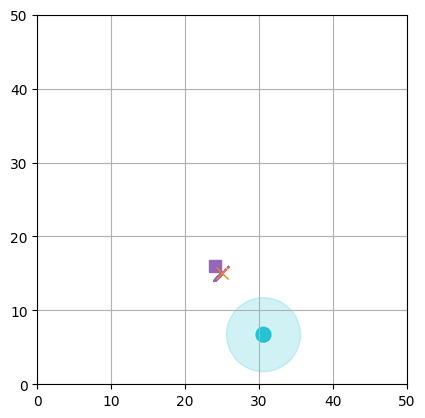

In [121]:
plot_joint_trajectory(
    joint_traj_dir=frozen_uav_trajs_dir / 'traj_0.csv',
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs()
)

In [122]:
# Go through each joint trajectory, but freeze the uav in place

freeze_uav_dfs = []
for traj_df in traj_dfs:
    # Get the individual agent and poi configs within the config
    rover_config = config['env']['agents']['rovers'][0]
    uav_config = config['env']['agents']['uavs'][0]
    poi_config = config['env']['pois']['hidden_pois'][0]

    # Set up the rover's neural network policy
    rover_nn = NeuralNetwork(
        num_inputs=12,
        num_hidden=[15],
        num_outputs=2,
        hidden_activation_func='tanh',
        output_activation_func='tanh'
    )
    rover_nn.setWeights(elite_team[0])

    # Now resim for 50 steps, but the uav is staying still
    resim_freeze_uav_eval_info = resim_env(
        num_steps = 50,
        rover_config = rover_config,
        uav_config = uav_config,
        poi_config = poi_config,
        poi_position = [
            float(traj_df['hidden_poi_0_x'][0]), 
            float(traj_df['hidden_poi_0_y'][0])
        ],
        uav_position = uav_config['position']['fixed'],
        rover_position = rover_config['position']['fixed'],
        uav_action = [0., 0.],
        rover_action = None,
        uav_policy_function = None,
        rover_policy_function = rover_nn
    )

    freeze_uav_dfs.append(build_traj_df(resim_freeze_uav_eval_info))

In [123]:
# Save all of the frozen dfs

# this awkward naming scheme is necessary for plotting tools
frozen_uav_trajs_dir = save_dir / 'frozen_uav' / 'traj' / 'traj'
if not os.path.exists(frozen_uav_trajs_dir):
    os.makedirs(frozen_uav_trajs_dir)

# save the trajectories
df_dirs = [frozen_uav_trajs_dir / ('traj_'+str(i)+'.csv') for i in range(len(traj_dfs))]
for df_dir, df in zip(df_dirs, freeze_uav_dfs):
    df.to_csv(df_dir, index=False)

# Save config
config_dir = save_dir / 'frozen_uav' / 'config.yaml'
with open(config_dir, "w") as file:
    yaml.dump(config, file, default_flow_style=False)


In [124]:
# Save plots of all the joint trajectories from the frozen dfs
base_out_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'outfigs' / '02_19_2025' / '01_influence' / 'frozen_uav'
for df_dir in df_dirs:
    plot_joint_trajectory(
        joint_traj_dir=df_dir,
        individual_colors=False,
        no_shading=False,
        plot_args=PlotArgs(
            output=base_out_dir / (df_dir.name+'.png')
        )
    )

In [125]:
# Let's look at the joint probability distribution of actions normally vs when the uav is frozen
dxs = []
dys = []
for traj_df in traj_dfs:
    dx = traj_df['rover_0_dx'].to_list()
    dy = traj_df['rover_0_dy'].to_list()
    dxs += dx
    dys += dy

freeze_uav_dxs = []
freeze_uav_dys = []
for traj_df in freeze_uav_dfs:
    dx = traj_df['rover_0_dx'].to_list()
    dy = traj_df['rover_0_dy'].to_list()
    freeze_uav_dxs += dx
    freeze_uav_dys += dy

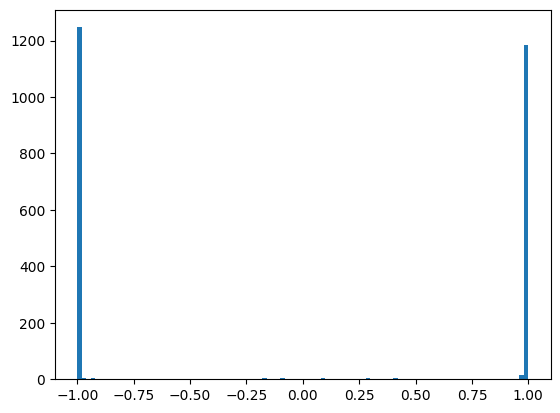

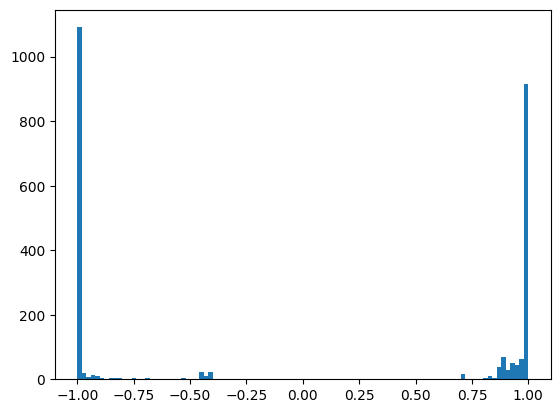

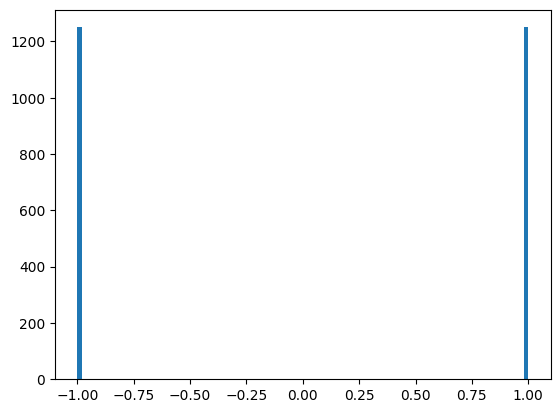

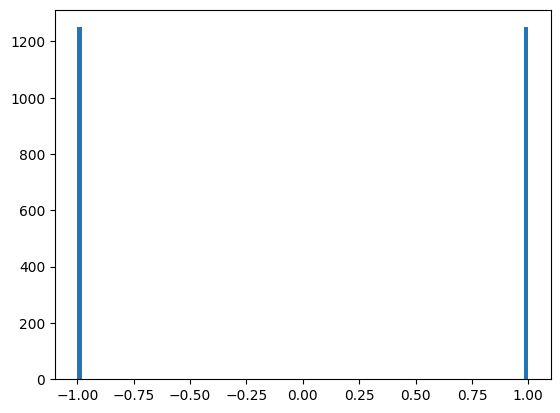

In [126]:
# Plotting histograms
plt.hist(dxs, bins=100);
plt.show()
plt.hist(dys, bins=100);
plt.show()
plt.hist(freeze_uav_dxs, bins=100);
plt.show()
plt.hist(freeze_uav_dys, bins=100);
plt.show()

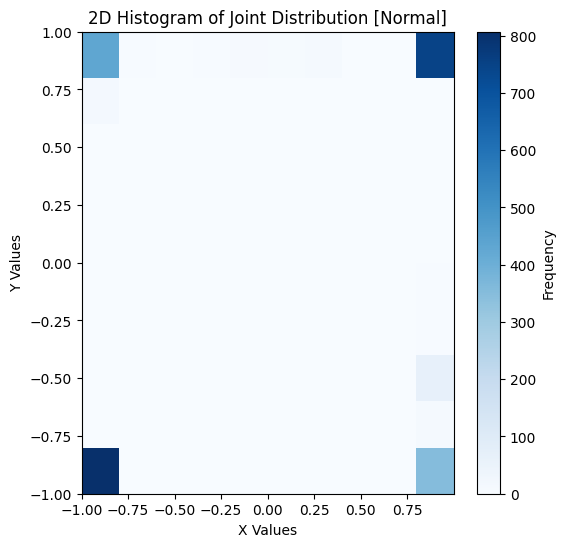

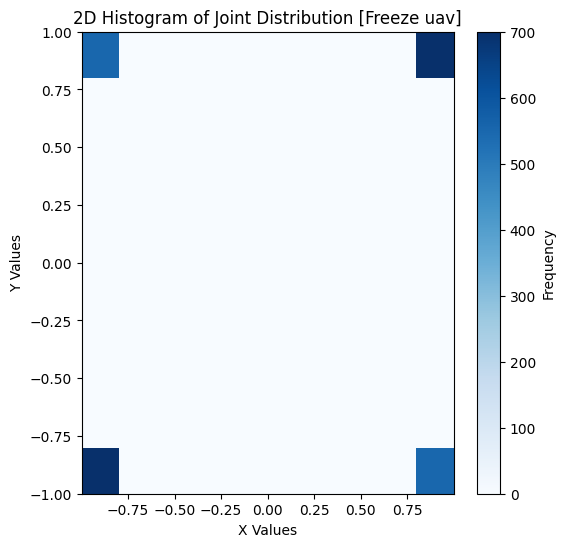

In [127]:
# Create 2D Histogram
num_bins = 10

plt.figure(figsize=(6, 6))
plt.hist2d(dxs, dys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Normal]')

plt.show()

plt.figure(figsize=(6, 6))
plt.hist2d(freeze_uav_dxs, freeze_uav_dys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Freeze uav]')

plt.show()

In [128]:
# There are only minor differences in actions. What about states?
xs = []
ys = []
for traj_df in traj_dfs:
    xs += traj_df['rover_0_x'].to_list()
    ys += traj_df['rover_0_y'].to_list()

freeze_uav_xs = []
freeze_uav_ys = []
for traj_df in freeze_uav_dfs:
    freeze_uav_xs += traj_df['rover_0_x'].to_list()
    freeze_uav_ys += traj_df['rover_0_y'].to_list()

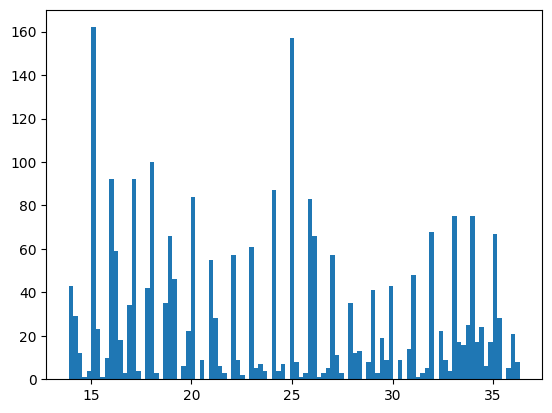

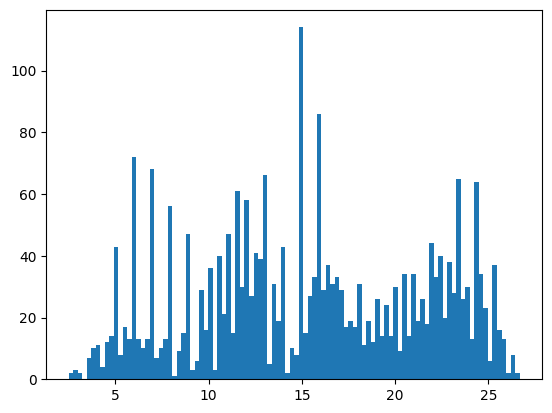

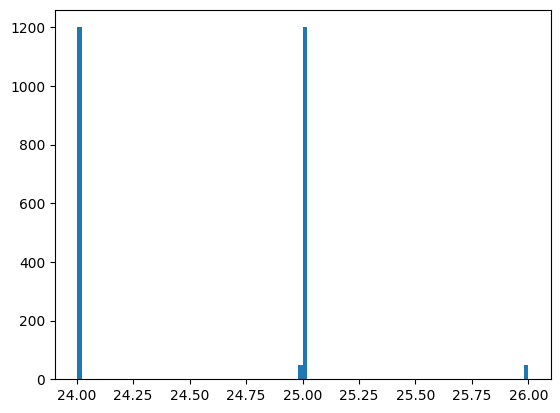

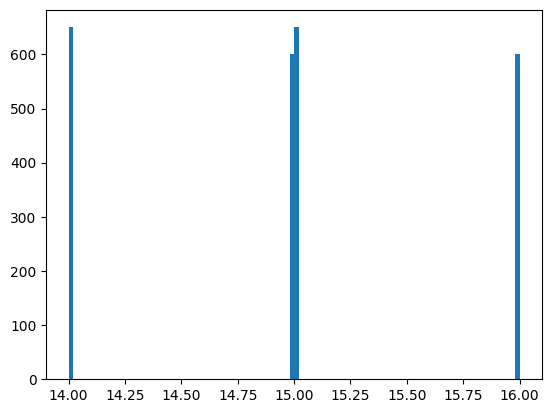

In [129]:
# Plotting histograms
plt.hist(xs, bins=100);
plt.show()
plt.hist(ys, bins=100);
plt.show()
plt.hist(freeze_uav_xs, bins=100);
plt.show()
plt.hist(freeze_uav_ys, bins=100);
plt.show()

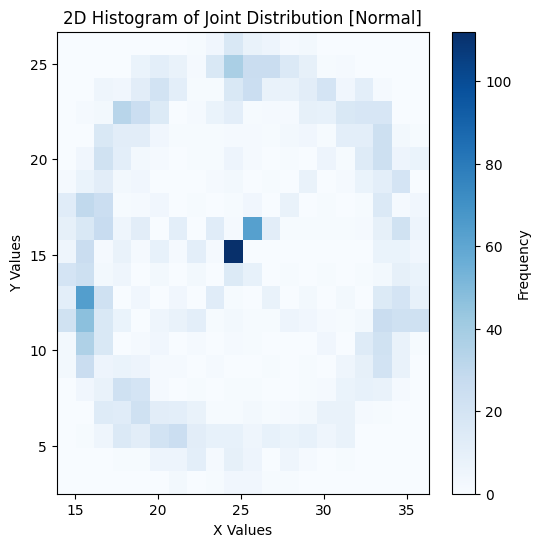

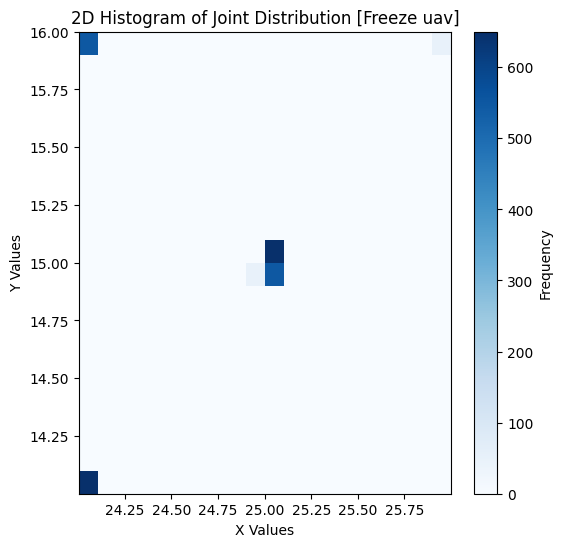

In [130]:
# Create 2D Histogram
num_bins = 20

plt.figure(figsize=(6, 6))
plt.hist2d(xs, ys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Normal]')

plt.show()

plt.figure(figsize=(6, 6))
plt.hist2d(freeze_uav_xs, freeze_uav_ys, bins=num_bins, cmap='Blues')

# Add color bar
plt.colorbar(label='Frequency')

# Labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('2D Histogram of Joint Distribution [Freeze uav]')

plt.show()

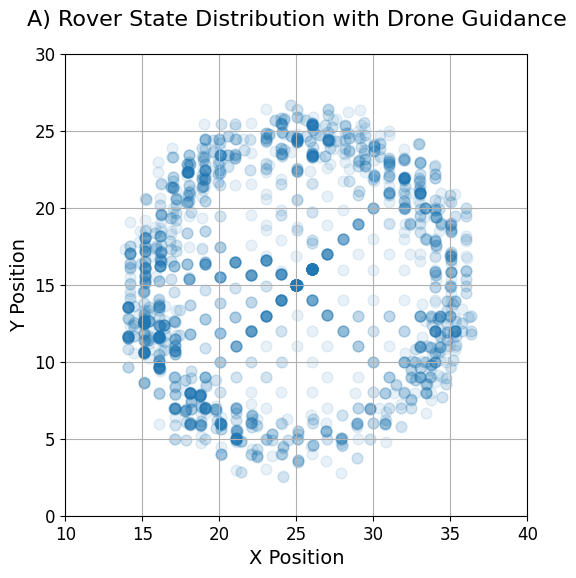

In [142]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = xs + np.random.normal(0, jitter_strength, size=len(xs))
y_jittered = ys + np.random.normal(0, jitter_strength, size=len(ys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:blue')

# Labels and title
ax.set_xlabel('X Position', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Y Position', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('A) Rover State Distribution with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([10,40])
ax.set_ylim([0,30])

fig.savefig(save_fig_dir / 'rover_state_dist.svg')

# fig.tight_layout()

# fig.show()

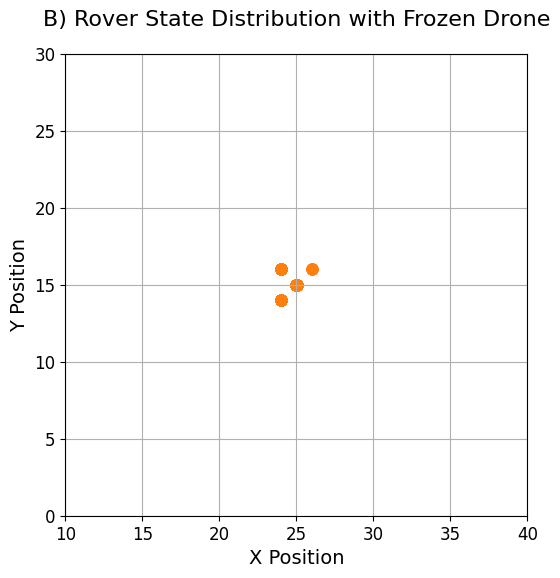

In [143]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = freeze_uav_xs + np.random.normal(0, jitter_strength, size=len(xs))
y_jittered = freeze_uav_ys + np.random.normal(0, jitter_strength, size=len(ys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:orange')

# Labels and title
ax.set_xlabel('X Position', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Y Position', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)
ax.set_title('B) Rover State Distribution with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([10,40])
ax.set_ylim([0,30])

fig.savefig(save_fig_dir / 'rover_state_dist_frozen_drone.svg')

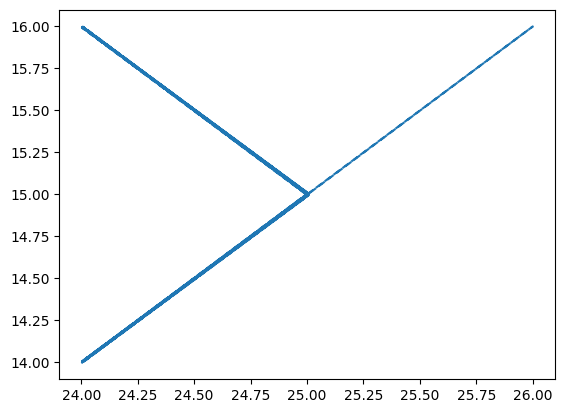

In [133]:
# freeze_uav_dfs[0]
plt.plot(freeze_uav_dfs[0]['rover_0_x'], freeze_uav_dfs[0]['rover_0_y'], '--')

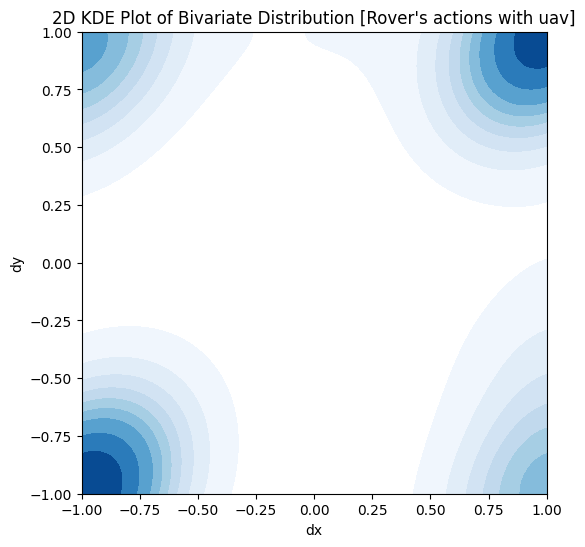

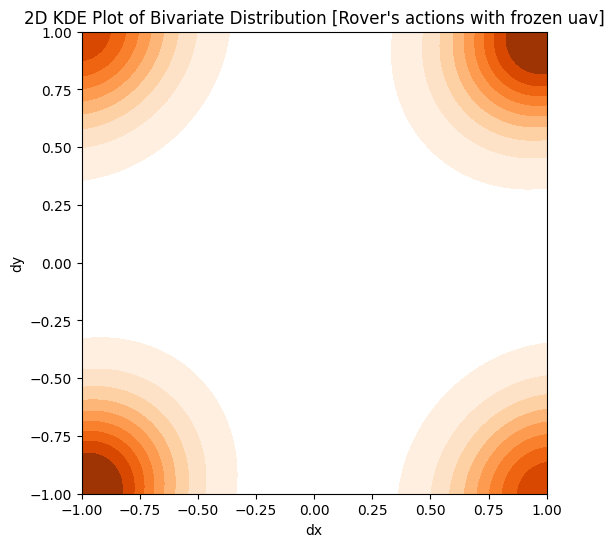

In [134]:
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.kdeplot(x=dxs, y=dys, cmap='Blues', fill=True)

# Labels and title
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('2D KDE Plot of Bivariate Distribution [Rover\'s actions with uav]')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.show()

plt.figure(figsize=(6, 6))
sns.kdeplot(x=freeze_uav_dxs, y=freeze_uav_dys, cmap='Oranges', fill=True)

# Labels and title
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('2D KDE Plot of Bivariate Distribution [Rover\'s actions with frozen uav]')

plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.show()

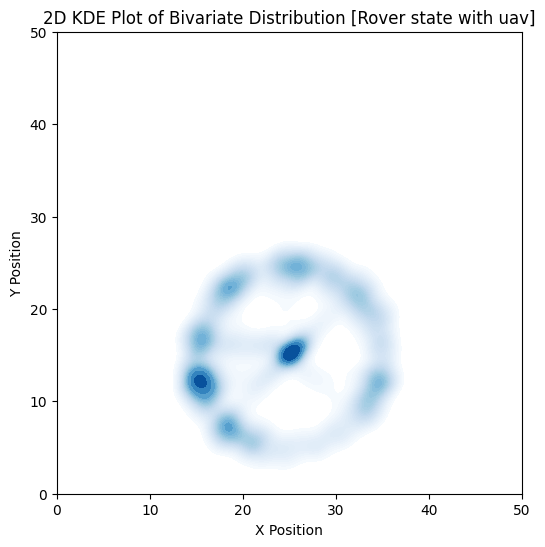

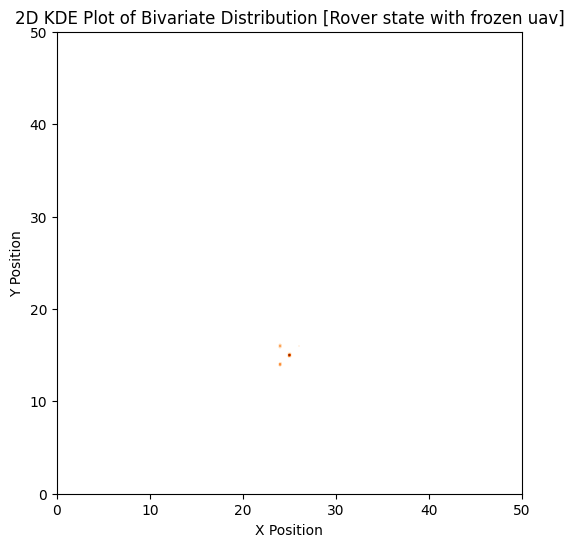

In [135]:
import seaborn as sns

gridsize = 100
bw_adjust = .5
levels = 30

plt.figure(figsize=(6, 6))
sns.kdeplot(x=xs, y=ys, cmap='Blues', fill=True, 
            bw_adjust=bw_adjust, gridsize=gridsize, levels=levels
            )

# Labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D KDE Plot of Bivariate Distribution [Rover state with uav]')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.show()

plt.figure(figsize=(6, 6))
sns.kdeplot(x=freeze_uav_xs, y=freeze_uav_ys, cmap='Oranges', fill=True,
             bw_adjust=bw_adjust, gridsize=gridsize, levels=levels
             )

# Labels and title
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D KDE Plot of Bivariate Distribution [Rover state with frozen uav]')

plt.xlim([0, 50])
plt.ylim([0, 50])

plt.show()

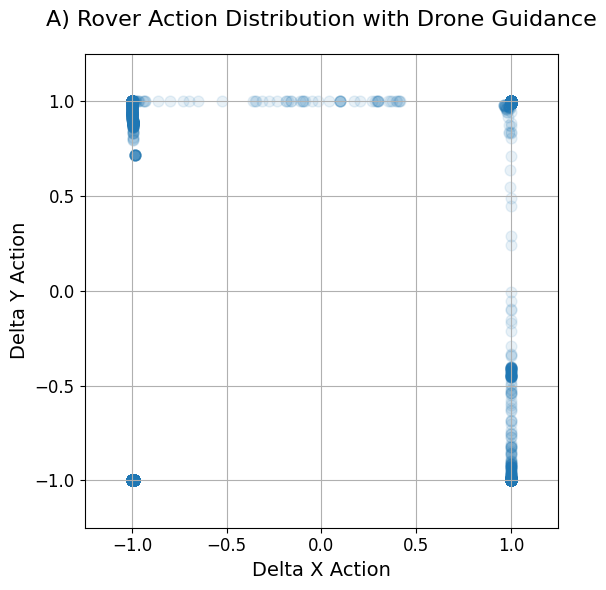

In [146]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = dxs + np.random.normal(0, jitter_strength, size=len(dxs))
y_jittered = dys + np.random.normal(0, jitter_strength, size=len(dys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:blue')

# Labels and title
ax.set_xlabel('Delta X Action', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Delta Y Action', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('A) Rover Action Distribution with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25,1.25])

fig.tight_layout()

fig.savefig(save_fig_dir / 'rover_action_dist.svg')

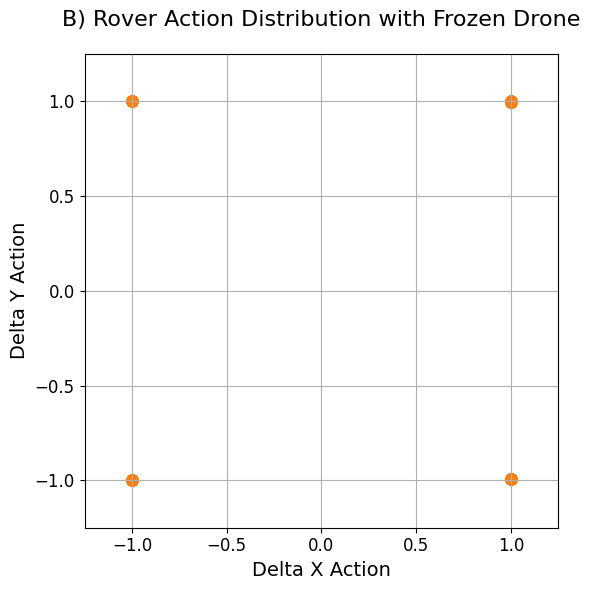

In [147]:
# Create 2D Histogram

# Add jitter (small random noise)
jitter_strength = 0.  # Adjust this value for more/less jitter
x_jittered = freeze_uav_dxs + np.random.normal(0, jitter_strength, size=len(dxs))
y_jittered = freeze_uav_dys + np.random.normal(0, jitter_strength, size=len(dys))

fig, ax = plt.subplots(1,1, figsize=(6, 6))
ax.grid()
# Adjust size and alpha to reveal more data points that overlap or fall closely together
ax.scatter(x_jittered, y_jittered, s=60, alpha=.1, color='tab:orange')

# Labels and title
ax.set_xlabel('Delta X Action', font_properties=font_manager.FontProperties(size=14))
ax.set_ylabel('Delta Y Action', font_properties=font_manager.FontProperties(size=14))
ax.tick_params(axis='both', labelsize=12)  # Use desired font size (e.g., 14)
ax.set_title('B) Rover Action Distribution with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)

ax.axis('square')
ax.set_xlim([-1.25, 1.25])
ax.set_ylim([-1.25,1.25])

fig.tight_layout()

fig.savefig(save_fig_dir / 'rover_action_dist_frozen_drone.svg')

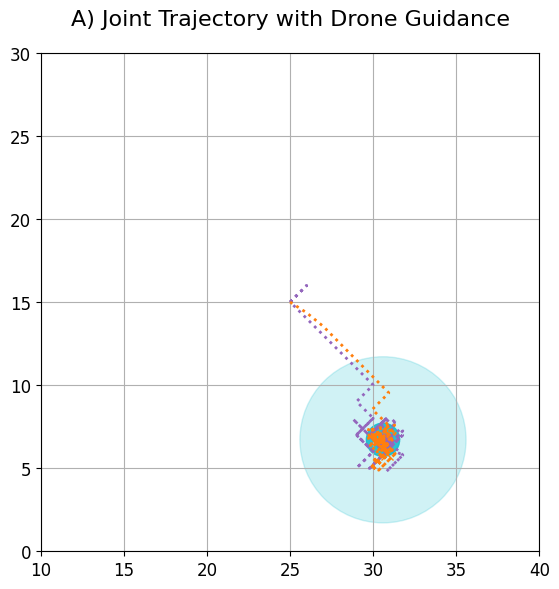

In [138]:
traj_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence' / 'original' / 'traj' / 'traj' / 'traj_0.csv'

fig = generate_joint_trajectory_plot(
    joint_traj_dir=traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        xlim=[10,40],
        ylim = [0,30]
    )
)

fig.set_size_inches(6,6)

ax = fig.axes[0]

ax.tick_params(axis='both', labelsize=12)
ax.set_title('A) Joint Trajectory with Drone Guidance', font_properties=font_manager.FontProperties(size=16), pad=20)
fig.tight_layout()

fig.savefig(save_fig_dir / 'joint_traj_0_normal.svg')

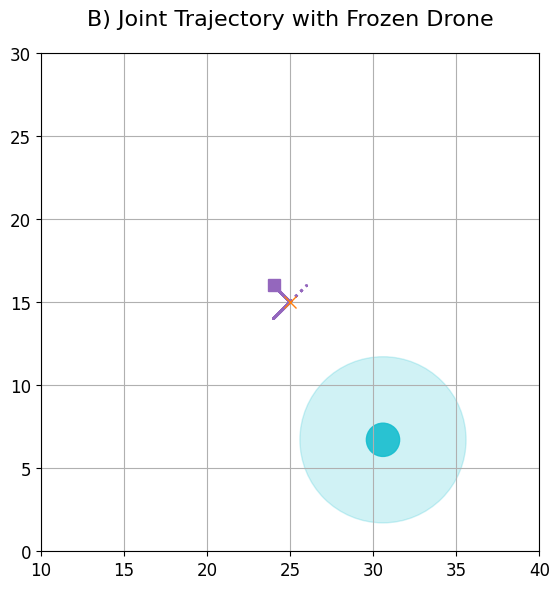

In [139]:
traj_dir = Path(os.path.expanduser('~')) / 'influence-shaping' / 'results' / '02_19_2025' / '01_influence' / 'frozen_uav' / 'traj' / 'traj' / 'traj_0.csv'

fig = generate_joint_trajectory_plot(
    joint_traj_dir=traj_dir,
    individual_colors=False,
    no_shading=False,
    plot_args=PlotArgs(
        xlim=[10,40],
        ylim = [0,30]
    )
)

fig.set_size_inches(6,6)

ax = fig.axes[0]

ax.tick_params(axis='both', labelsize=12)
ax.set_title('B) Joint Trajectory with Frozen Drone', font_properties=font_manager.FontProperties(size=16), pad=20)
fig.tight_layout()

fig.savefig(save_fig_dir / 'joint_traj_0_frozen_drone.svg')

In [140]:
# At a coarse level it is clear that the uav has a strong influence on the state of the rover, 
# but it's hard to tell anything from looking at the rover's actions.

# What about at a fine-grained level? What if we freeze 